# Classifying Audio using Spectrograms and CNNs

## Note on Data locations

I recommend putting the audio (WAV) and image (PNG) files in `data\audio` and `data\iamges` directories, respectively.

The `data\` directory is already included in the `.gitignore` file, and so these large binary files won't be included in commits.

### Example:

<img src="data_structure_example.png" style="widht:400px; height:auto;">

## Imports

In [8]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import pickle

## AudioFile class

- `file_path`: Path to the audio file
- `file_name`: Name of the audio file (extracted from the path)
- `label`: Label of the audio file (derived from the parent directory name)
- `audio`: Loaded audio data
- `sample_rate`: Sampling rate of the audio file
- `duration`: Duration of the audio file in seconds

### Methods

- `display_waveform()`: Display the waveform of the audio file
- `play()`: Play the audio file and return an audio player widget
- `trim(top_db=30)`: Trim silent parts of the audio using a decibel threshold
- `create_spectrogram()`: Generate a mel spectrogram of the audio file
- `show_spectrogram()`: Display the spectrogram of the audio file
- `save_spectrogram(output_dir=None, skip_existing=True)`: Save the spectrogram as a PNG file


In [2]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


### Example of using AudioFile class

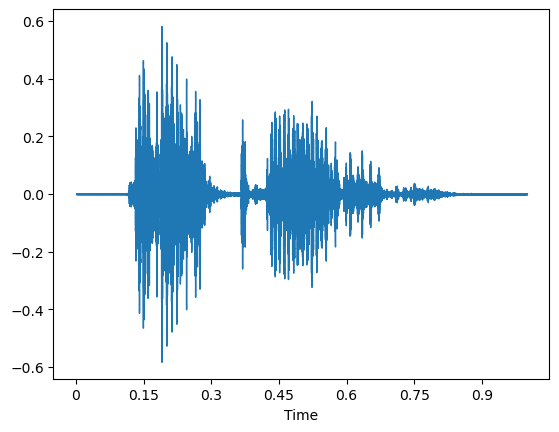

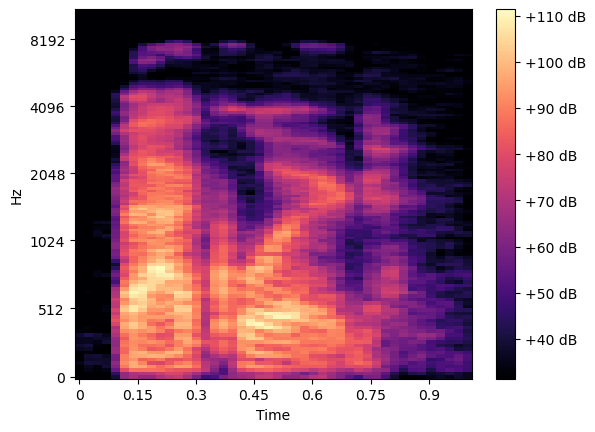

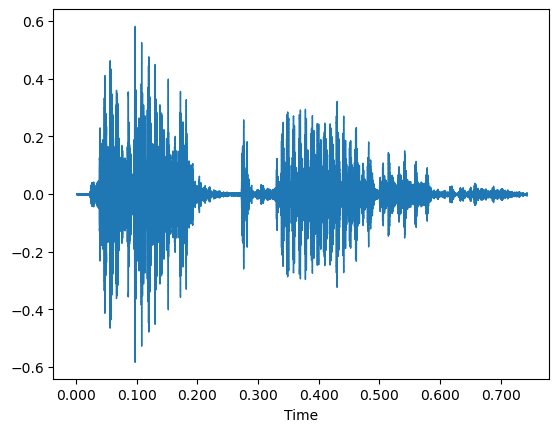

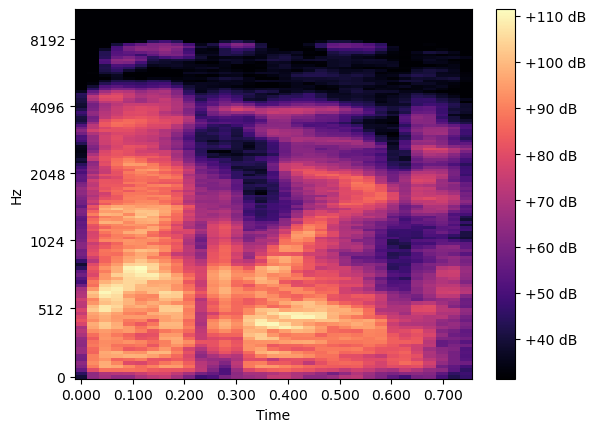

In [3]:
_audio_file = os.path.join("data", "audio", "Speech Commands", "backward", "0a2b400e_nohash_0.wav")
test_audio = AudioFile(_audio_file)

test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.trim()
test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.play()   # NOTE: play() has to be in its own cell or the last line; otherwise it doesn't show

## Convert Audio Files to Spectrograms

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


### NOTE:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [4]:
input_dir = os.path.join("data", "audio","Speech Commands")
output_dir = os.path.join("data", "images", "Speech Commands")

def process_directory(input_dir, output_dir, skip_existing=True):
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        print(f"Processing directory: {os.path.basename(root)}")
        for file in files:
            if file.endswith('.wav'):
                # load file
                audio = AudioFile(os.path.join(root, file))
                # save spectrogram
                audio.save_spectrogram(output_dir, skip_existing=skip_existing)


# process_directory(input_dir, output_dir, skip_existing=True)

# Data Pipeline

In [5]:
# Define paths
data_folder='data/audio/Speech Commands'
files = [f for f in os.listdir(data_folder) if f != '.DS_Store'] #removes hidden files on Macs
pd.DataFrame(files,columns=['Files']).sort_values(by='Files', ascending=True).reset_index(drop=True)

,Files
0,_background_noise_
1,backward
2,bed
3,bird
4,cat
5,dog
6,down
7,eight
8,five
9,follow


In [6]:
def count(path):
    size = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        files = [file for file in os.listdir(folder_path) if file != '.DS_Store']  # Filter inside subdirectories
        size.append(len(files))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=folders)  
    
file_counts = count(data_folder)
print("File Counts:", f"file_counts")
file_counts.sort_values(by='Number Of Sample', ascending=False)

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


## Create time series dataset

In [6]:
def create_dataset(path):
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        if os.listdir(folder_path):
            files = [file for file in os.listdir(folder_path) if file != '.DS_Store']
            for fil in files:
                file_path = os.path.join(folder_path,fil)
                audio_file = AudioFile(file_path)
                audio_data = audio_file.audio
                sample_rate = audio_file.sample_rate
                duration = audio_file.duration
                file_paths.append(file_path)
                data.append(audio_data)
                sample.append(sample_rate)
                label.append(folder)
                durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)
audio_df = pd.DataFrame()
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths,label,sample,durations
audio_df

KeyboardInterrupt: 

In [ ]:
# Create a dictionary 
dataset = {
    "audio_data": audio_data,  # List of raw audio arrays
    "file_paths": file_paths,
    "Label": label,
    "sample": sample,
    "duration": durations
}

# Save dictionary to a pickle file
with open("audio_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

print("Entire dataset saved to audio_dataset.pkl")

In [9]:
# Open pickle file 
with open("audio_dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

# Extract each component
audio_data = dataset["audio_data"]
file_paths = dataset["file_paths"]
label = dataset["Label"]
sample = dataset["sample"]
durations = dataset["duration"]

audio_df = pd.DataFrame({
    "file_paths": file_paths,
    "Label": label,
    "sample": sample,
    "duration": durations
})

print("Dataset reloaded from pickle.")

Dataset reloaded from pickle.


### Create numbered labels

In [8]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


### Label data with numbered labels

In [9]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
...,...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34


In [10]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

## Exploratory Data Analysis

In [11]:
audio_df.shape

(105829, 5)

In [12]:
def count(path):
    size = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        files = [file for file in os.listdir(folder_path) if file != '.DS_Store']  # Filter inside subdirectories
        size.append(len(files))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=folders)  
    
file_counts = count(data_folder)
file_counts.sort_values(by='Number Of Sample', ascending=False)

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


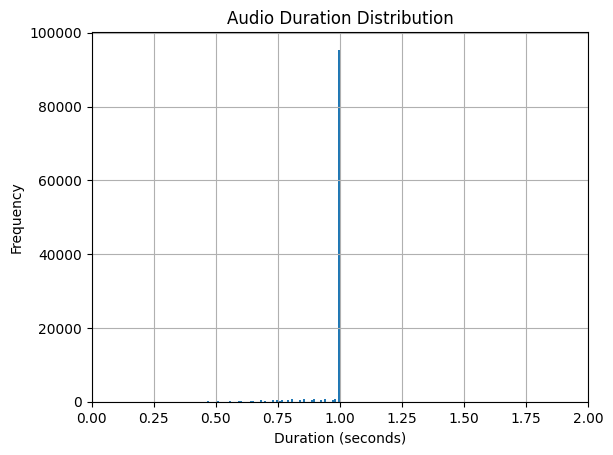

In [15]:
audio_df["duration"].hist(bins=100)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.xlim(0,2)
plt.show()

In [16]:
# Find how the indeces for files that are less than 1 second
invalid_indices = [i for i, arr in enumerate(audio_data) if len(arr) != 22050]

# Print the # of files less than 1 second
print("# of files less than 1 second:", len(invalid_indices))

# Will put code for padding the data in the data pipeline section

# of files less than 1 second: 10435


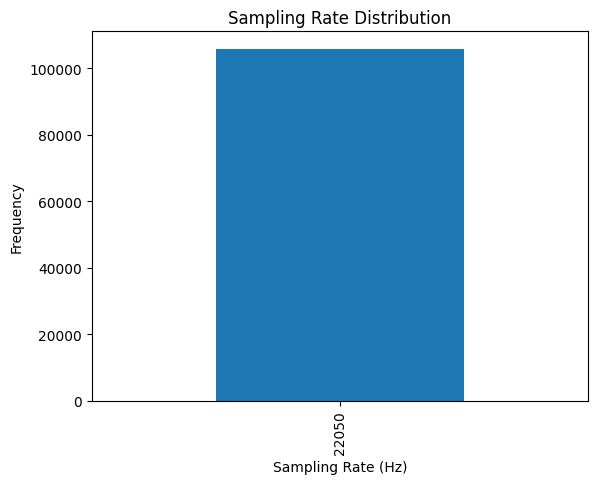

In [17]:
audio_df["sample"].value_counts().plot(kind="bar")
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Frequency")
plt.show()

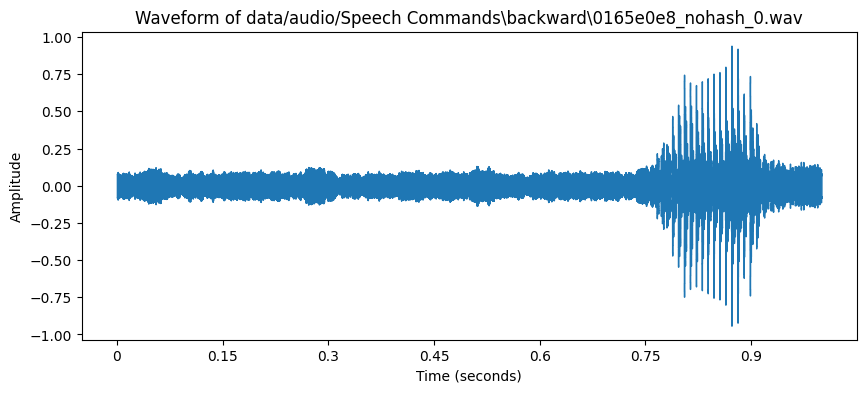

In [18]:
sample_data = audio_data[0]
sr = audio_df['sample'].iloc[0]
plt.figure(figsize=(10, 4))
librosa.display.waveshow(sample_data, sr=sr)
plt.title(f"Waveform of {audio_df['file_paths'].iloc[0]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [19]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="hz", cmap="viridis")
plt.title(f"Spectrogram of {audio_df['sample'].iloc[0]}")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

NameError: name 'y' is not defined

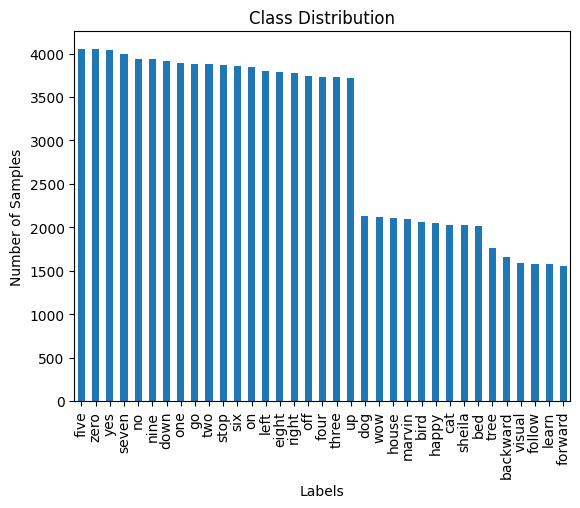

In [20]:
audio_df["Label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [21]:
mfccs = librosa.feature.mfcc(y=sample_data, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time", cmap="viridis")
plt.title("MFCCs")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

NameError: name 'y' is not defined

In [ ]:
audio_df.iloc[0]

## Extracting pitch

In [22]:
## attempting with librosa normalization
sample_data = audio_data[300]
sr = audio_df['sample'].iloc[0]
f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
print(f0)

[177.3951278  137.49835613 140.09827687 139.0197277  138.43823336
 129.29907332 138.56121108 138.48077744 134.89065433 129.39689759
 132.56656903 130.87757378 130.14673414 130.85363706 134.83766241
 135.54150369 130.99816063 102.59798146  50.67302206 311.30507972
 316.53972255  43.93705333 110.51596362 141.10401467 143.10253949
 146.54638248 198.35467903 564.14669279 577.29082135 583.19267874
  99.85516751 101.06464925 101.36201454 100.78375406 100.80875214
 100.99727349  22.1986608   23.36818144  23.34695718  83.7688575
 329.53953722 335.84115446 347.04839799  44.38453243]


In [23]:
print(np.mean(f0))

168.92215222014883


In [24]:
## Functions to return pitch and average pitch of sample

def return_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return f0

def average_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return np.mean(f0)

In [25]:
return_pitch(550)

array([ 70.68767483,  21.5542522 ,  50.79981954,  24.95486899,
        25.0326935 ,  51.01065548,  50.24108197,  50.22145004,
        24.86637158,  24.79756127,  24.7613659 ,  49.17792778,
        49.57774168,  50.05980921,  52.23783638,  48.34091461,
        48.62269542,  49.23782774,  49.6093606 ,  48.859958  ,
        52.67212496, 220.55702361, 202.86583925, 192.26740105,
       185.081117  , 183.28786547, 191.42396584, 214.01867134,
       212.07096207, 209.74221498, 206.75472163, 203.419273  ,
       198.96395319, 183.66986107,  50.02493403,  50.78274063,
       824.91289699,  25.40450473,  53.01161494, 193.85270763,
       168.9341857 , 165.00100855, 164.15119106])

In [26]:
print(average_pitch(550))

121.33773594067719


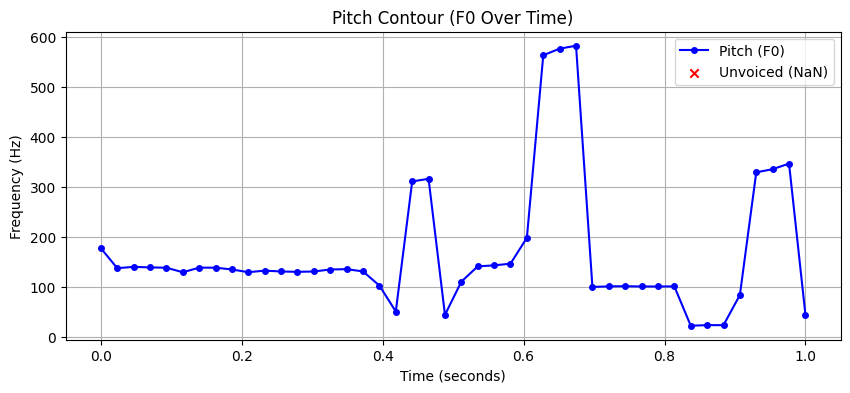

In [27]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

In [28]:
# trying different audio sample
sample_data2 = audio_data[60000]
f0 = librosa.yin(sample_data2, fmin=20, fmax=1000)
print(f0)
print(audio_df.iloc[60000])

[632.32426435 782.60298837 115.47280357 101.89753663  64.94259065
  25.91322028 105.61195898 433.09438071 157.279593    61.69782006
 122.25969716 120.13403592 118.60051595 117.91859384 116.19508998
 114.32671194 112.49367688 110.52018743 108.4629966  107.05929796
 106.8393759  107.43598741 112.29251869 123.12863936  32.66466266
 114.88501601  33.9777374   34.45171432 100.65058993  41.71975798
 297.55414361  24.86789683  46.4501533  122.52939285  69.98524968
 165.83737519 164.12862678 277.33325512  78.14151299  47.91151593
 306.41100446 151.93707076  23.68443129  23.7578789 ]
file_paths        data/audio/Speech Commands\one\226537ab_nohash...
Label                                                           one
sample                                                        22050
duration                                                        1.0
Numbered Label                                                   21
Name: 60000, dtype: object


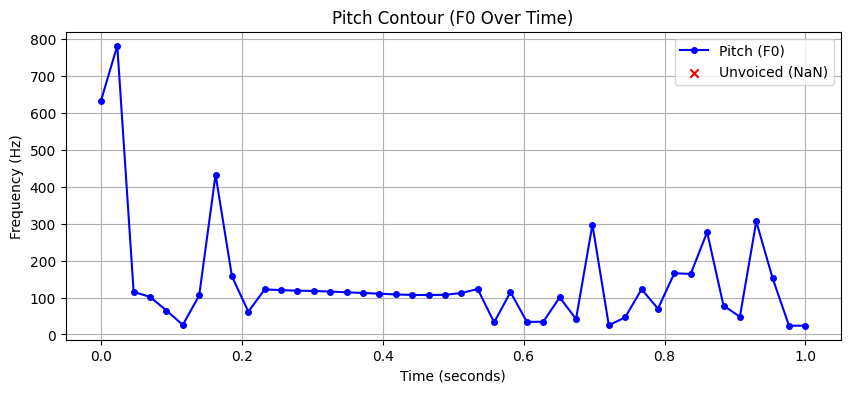

In [29]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data2) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels 
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

## Extracting pitch statistics across dataset

In [30]:
dataset_path = r"data\audio\Speech Commands"
# List to store pitch data
pitch_data = []

# Iterate through each word directory
for word in os.listdir(dataset_path):
    word_path = os.path.join(dataset_path, word)
    
    # Check if it's a directory (i.e., a class)
    if os.path.isdir(word_path):
        # Iterate through audio files in the word directory
        for file in os.listdir(word_path):
            if file.endswith(".wav"):
                file_path = os.path.join(word_path, file)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute pitch (F0) using YIN
                # Can change fmin to lower value and fmax to higher value
                f0 = librosa.yin(y, fmin=50, fmax=500)

                # Remove NaNs (unvoiced regions)
                f0 = f0[~np.isnan(f0)]
                
                if len(f0) > 0:  # Only consider files where pitch was detected
                    pitch_data.append({
                        "word": word,
                        "file": file,
                        "mean_f0": np.mean(f0),
                        "median_f0": np.median(f0),
                        "std_f0": np.std(f0),
                        "min_f0": np.min(f0),
                        "max_f0": np.max(f0)
                    })

In [31]:
# Convert to Pandas DataFrame
pitch_df = pd.DataFrame(pitch_data)

# Save to CSV for further analysis
pitch_df.to_csv("pitch_statistics.csv", index=False)

# Display first few rows
print(pitch_df.head())

       word                   file     mean_f0   median_f0      std_f0  \
0  backward  0165e0e8_nohash_0.wav  137.148522   88.974426   81.460232   
1  backward  017c4098_nohash_0.wav  144.911786  119.826446  104.334736   
2  backward  017c4098_nohash_1.wav  141.948204  111.207695  109.615286   
3  backward  017c4098_nohash_2.wav  169.122299  118.557587  118.709701   
4  backward  017c4098_nohash_3.wav  154.573500  146.064696  104.684598   

      min_f0      max_f0  
0  61.079097  409.261369  
1  53.170360  447.479939  
2  50.763738  478.063368  
3  50.990918  501.136364  
4  53.892310  437.991516  


In [32]:
## Visualizing the pitch statistics

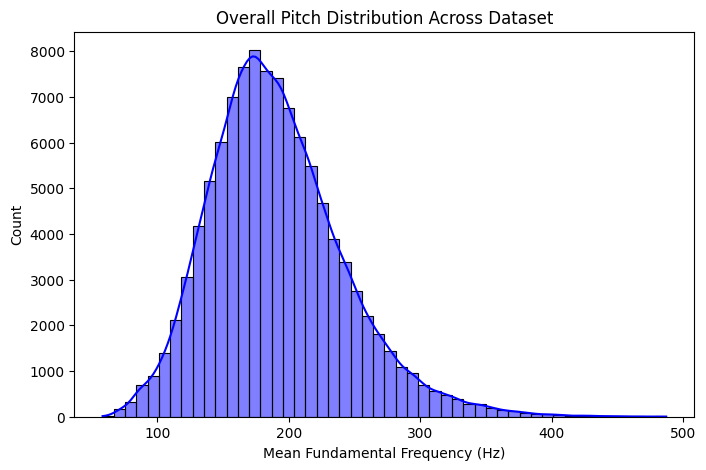

In [33]:
plt.figure(figsize=(8, 5))
sns.histplot(pitch_df["mean_f0"], bins=50, kde=True, color="blue")
plt.xlabel("Mean Fundamental Frequency (Hz)")
plt.ylabel("Count")
plt.title("Overall Pitch Distribution Across Dataset")
plt.show()

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

https://www.dpamicrophones.com/mic-university/background-knowledge/facts-about-speech-intelligibility/#:~:text=In%20general%2C%20the%20fundamental%20frequency,f0%20is%20around%20300%20Hz.

Our dataset follows this general distrubtion of pitch 

In [34]:
## pitch distribution per word

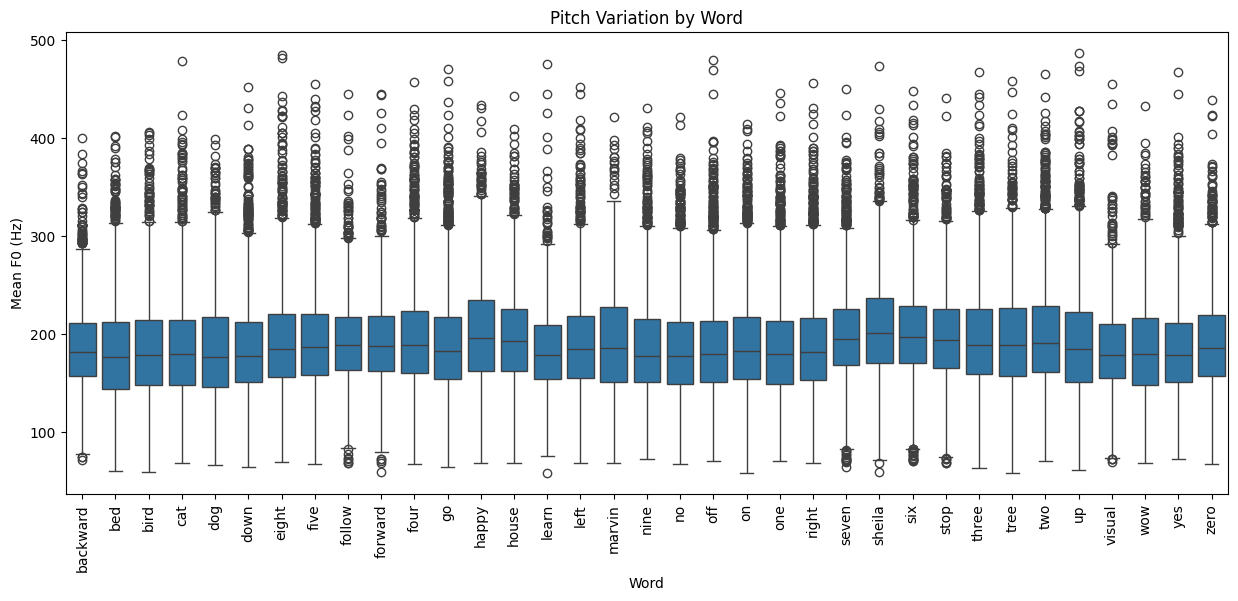

In [35]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=pitch_df, x="word", y="mean_f0")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Variation by Word")
plt.show()

In [36]:
## Density of Pitch per word

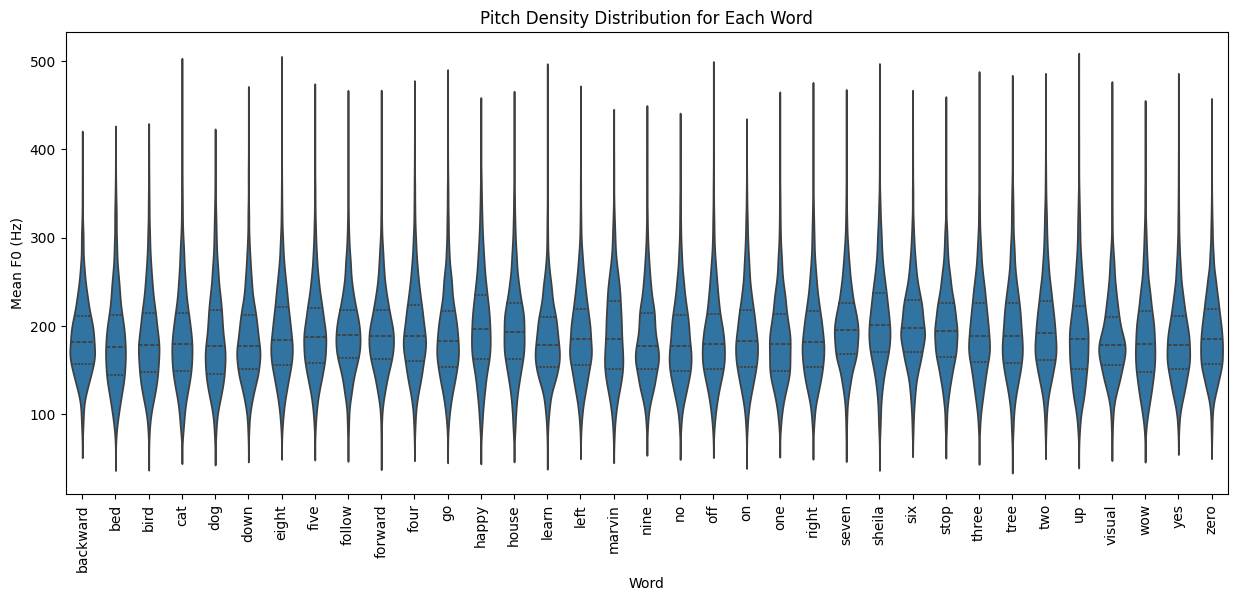

In [37]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=pitch_df, x="word", y="mean_f0", inner="quartile")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Density Distribution for Each Word")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\234779674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")


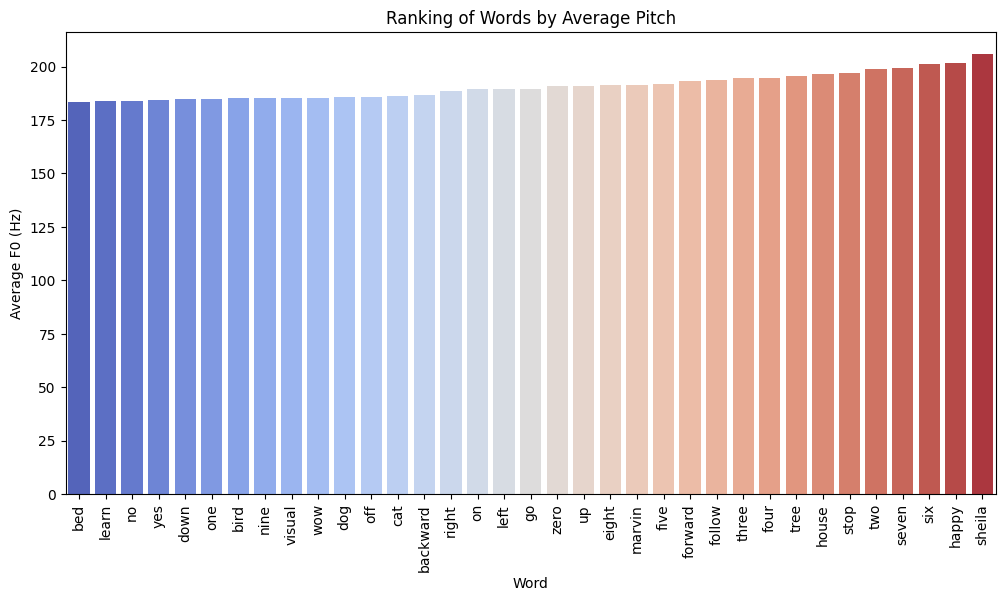

In [38]:
# Sort words by average pitch
word_avg_pitch = pitch_df.groupby("word")["mean_f0"].mean().sort_values()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Average F0 (Hz)")
plt.title("Ranking of Words by Average Pitch")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\2452879583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")


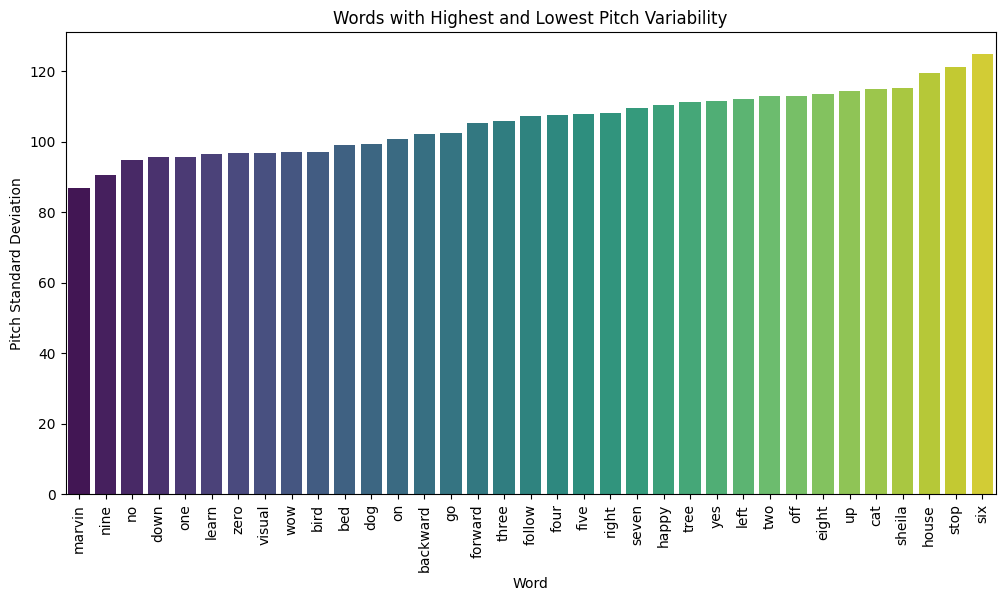

In [39]:
word_std_pitch = pitch_df.groupby("word")["std_f0"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Pitch Standard Deviation")
plt.title("Words with Highest and Lowest Pitch Variability")
plt.show()

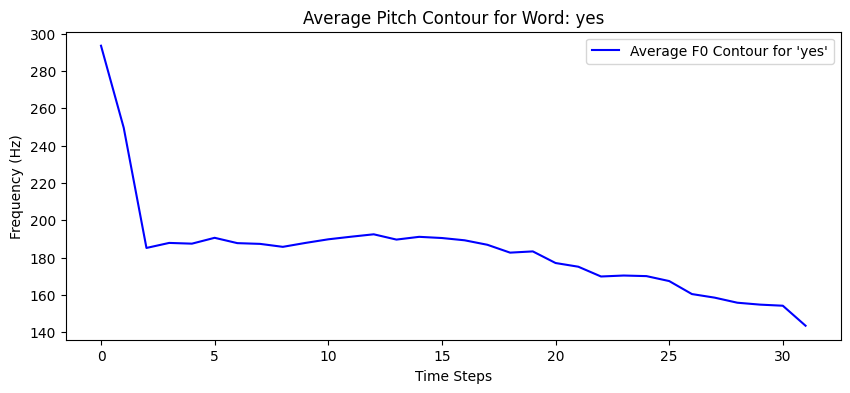

In [40]:
# word to analyze
target_word = "yes"

# Extract pitch sequences 
word_files = pitch_df[pitch_df["word"] == target_word]["file"]

all_f0_curves = []

for file in word_files:
    file_path = os.path.join(dataset_path, target_word, file)
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=50, fmax=500)
    f0 = f0[~np.isnan(f0)]  # Remove NaNs
    all_f0_curves.append(f0)

# Compute mean pitch contour
max_len = max(len(f) for f in all_f0_curves)
aligned_f0 = np.array([np.pad(f, (0, max_len - len(f)), mode='constant', constant_values=np.nan) for f in all_f0_curves])
mean_f0_contour = np.nanmean(aligned_f0, axis=0)

# Plot the mean pitch contour
plt.figure(figsize=(10, 4))
plt.plot(mean_f0_contour, label=f"Average F0 Contour for '{target_word}'", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Frequency (Hz)")
plt.title(f"Average Pitch Contour for Word: {target_word}")
plt.legend()
plt.show()


## Zero crossing rate

In [41]:
sample_data = audio_data[50000]
print(audio_df['file_paths'].iloc[50000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\no\879a2b38_nohash_2.wav


array([[0.01513672, 0.02636719, 0.07177734, 0.12304688, 0.14599609,
        0.15673828, 0.11669922, 0.07666016, 0.05859375, 0.04931641,
        0.06542969, 0.05761719, 0.04882812, 0.04003906, 0.02246094,
        0.01660156, 0.01611328, 0.01660156, 0.02441406, 0.03808594,
        0.04980469, 0.05908203, 0.06201172, 0.05566406, 0.05078125,
        0.04589844, 0.03857422, 0.03613281, 0.03369141, 0.03173828,
        0.03125   , 0.02978516, 0.03369141, 0.04248047, 0.04296875,
        0.04150391, 0.03320312, 0.02148438, 0.02978516, 0.03173828,
        0.03808594, 0.03857422, 0.02197266, 0.01464844]])

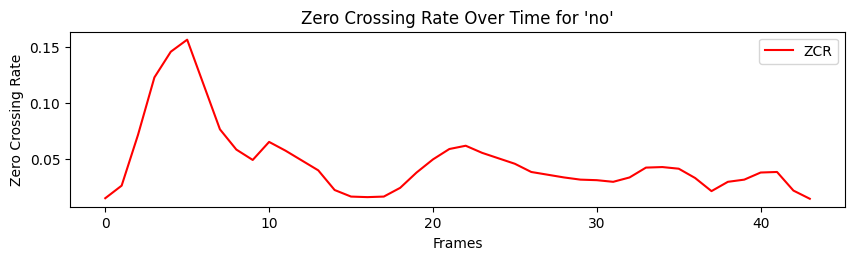

In [42]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'no'")
plt.legend()
plt.show()

In [43]:
sample_data = audio_data[70000]
print(audio_df['file_paths'].iloc[70000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\seven\b7e9f841_nohash_0.wav


array([[0.12451172, 0.18212891, 0.25292969, 0.22802734, 0.19628906,
        0.15429688, 0.11181641, 0.08105469, 0.05419922, 0.10205078,
        0.12988281, 0.1796875 , 0.29541016, 0.34130859, 0.40966797,
        0.48535156, 0.49707031, 0.52246094, 0.52929688, 0.5234375 ,
        0.44873047, 0.33740234, 0.25195312, 0.16601562, 0.14794922,
        0.15380859, 0.14355469, 0.13476562, 0.11962891, 0.11962891,
        0.10253906, 0.10693359, 0.10595703, 0.09960938, 0.11669922,
        0.12255859, 0.14257812, 0.16845703, 0.18164062, 0.16503906,
        0.14355469, 0.12451172, 0.07666016, 0.05371094]])

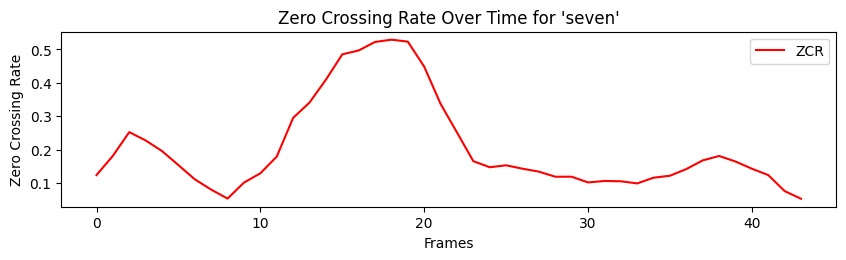

In [44]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'seven'")
plt.legend()
plt.show()

## MFCCs

In [10]:
# Parameters for MFCC extraction
n_mfcc = 13  # Number of MFCC coefficients
max_pad_len = 44  # To ensure all MFCCs have the same length

def extract_mfcc(file_path):
    """Extract MFCC features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=16000)  # Load audio file with a fixed sample rate
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Compute MFCCs
        
        # Padding or truncation to ensure all have same length
        if mfccs.shape[1] < max_pad_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        
        return mfccs.flatten()  # Convert to 1D array for storage
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc * max_pad_len)  # Return zeros for faulty files

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Parameters
n_mfcc = 13  # Number of MFCC coefficients
max_pad_len = 44  # Ensure fixed feature length
batch_size = 5000  # Process in batches

def extract_mfcc(file_path):
    """Extract MFCC features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=16000)  # Load audio with fixed sample rate
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Ensure all MFCCs have the same length
        if mfccs.shape[1] < max_pad_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        
        return mfccs.flatten()  # Convert to 1D array
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc * max_pad_len)  # Return zeros for faulty files

# Storage
mfcc_data = []
labels = []
saved_batches = 0

# Iterate through dataset
for word in tqdm(os.listdir(data_folder), desc="Processing words"):
    word_path = os.path.join(data_folder, word)
    
    if os.path.isdir(word_path):  # Ensure it's a folder
        for file in os.listdir(word_path):
            if file.endswith(".wav"):  # Process only audio files
                file_path = os.path.join(word_path, file)
                mfcc_features = extract_mfcc(file_path)
                mfcc_data.append(mfcc_features)
                labels.append(word)  # Folder name is label

            # Save batch to CSV
            if len(mfcc_data) >= batch_size:
                df = pd.DataFrame(mfcc_data)
                df["Label"] = labels
                df.to_csv(f"mfcc_features_batch_{saved_batches}.csv", index=False)
                saved_batches += 1

                # Clear memory
                mfcc_data.clear()
                labels.clear()

# Save any remaining data
if mfcc_data:
    df = pd.DataFrame(mfcc_data)
    df["Label"] = labels
    df.to_csv(f"mfcc_features_batch_{saved_batches}.csv", index=False)

print(f"MFCC feature extraction completed! Data saved in {saved_batches+1} batches.")

Processing words: 100%|██████████| 36/36 [9:49:32<00:00, 982.56s/it]    


MFCC feature extraction completed! Data saved in 22 batches.


In [12]:
import pandas as pd
import glob

# Load all batch files
csv_files = glob.glob("mfcc_features_batch_*.csv")

# Merge all into one DataFrame
df_all = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Save the final dataset
df_all.to_csv("mfcc_features_final.csv", index=False)

### Visualize Heatmaps for Individual Words

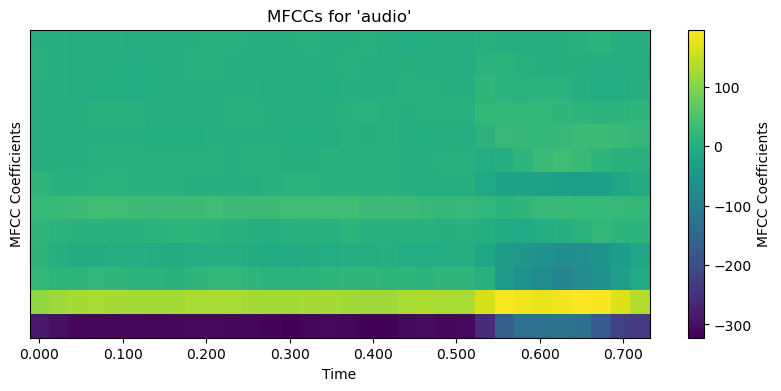

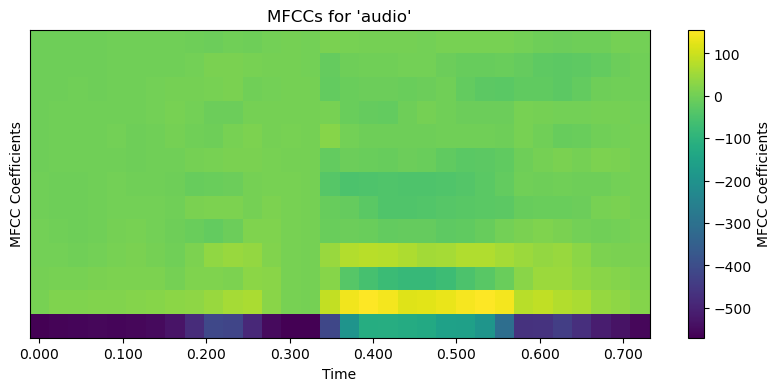

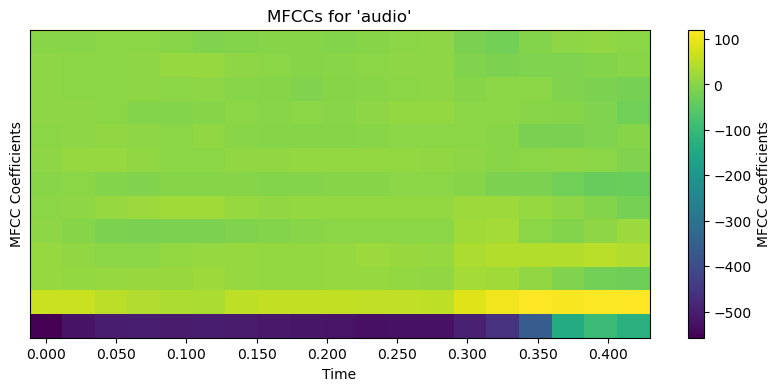

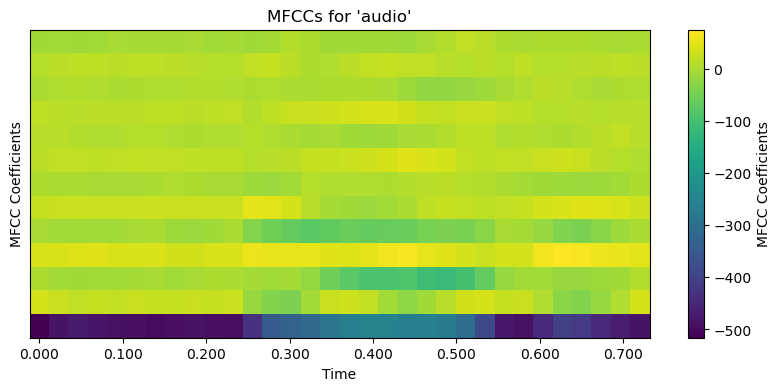

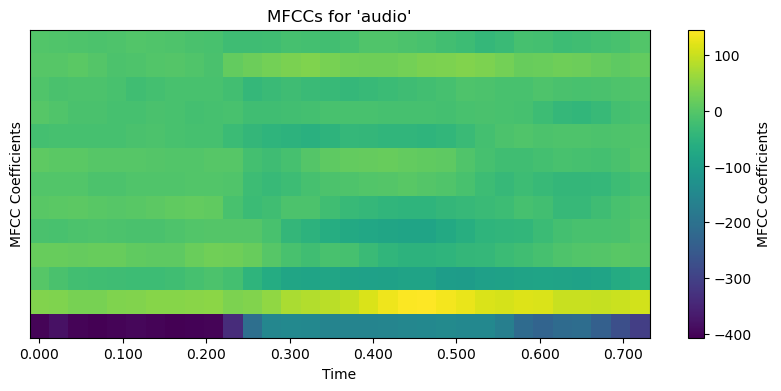

In [13]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to plot MFCC heatmap
def plot_mfcc(file_path, word):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis="time", cmap="viridis")
    plt.colorbar(label="MFCC Coefficients")
    plt.title(f"MFCCs for '{word}'")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()

# Plot MFCCs for a sample of different words
sample_files = []
for word in os.listdir(data_folder):
    word_path = os.path.join(data_folder, word)
    if os.path.isdir(word_path):
        files = [f for f in os.listdir(word_path) if f.endswith(".wav")]
        if files:
            sample_files.append(os.path.join(word_path, files[0]))  # Pick first file

# Display MFCC heatmaps for 5 words
for sample_file in sample_files[:5]:  
    word = sample_file.split("/")[-2]  # Extract word label
    plot_mfcc(sample_file, word)

### Boxplot of MFCC Distributions Across Words

In [ ]:
import seaborn as sns
import pandas as pd

# Load MFCC dataset
df = pd.read_csv("mfcc_features_final.csv")  # Assuming we have a CSV from previous steps

# Select only a few MFCCs for visualization
mfcc_columns = df.columns[:13]  # Selecting the first 13 MFCCs

# Melt the DataFrame for visualization
df_melted = df.melt(id_vars=["Label"], value_vars=mfcc_columns, var_name="MFCC Coefficient", value_name="Value")

# Plot boxplot
plt.figure(figsize=(14, 6))
sns.violinplot(x="Label", y="Value", data=df_melted, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("MFCC Distribution Across Different Words")
plt.xlabel("Word Label")
plt.ylabel("MFCC Value")
plt.show()

### Dimensionality Reducation with PCA

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Load dataset
df = pd.read_csv("mfcc_features_final.csv")
X = df.iloc[:, :-1].values  # Exclude label column
y = df["Label"].values

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Label"] = y

# Plot PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Label", data=df_pca, palette="tab20", alpha=0.7)
plt.title("PCA: MFCC Features Reduced to 2D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Models

## K-Means 

In [47]:
lengths = [len(arr) for arr in audio_data_padded]
for length in lengths:
    if length != 22050:
        print(length)

In [48]:
audio_data_arr = np.array(audio_data_padded)
type(audio_data_arr)

numpy.ndarray

In [116]:
inertia = []
K_range = range(1, 11)  # Test for k=1 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)

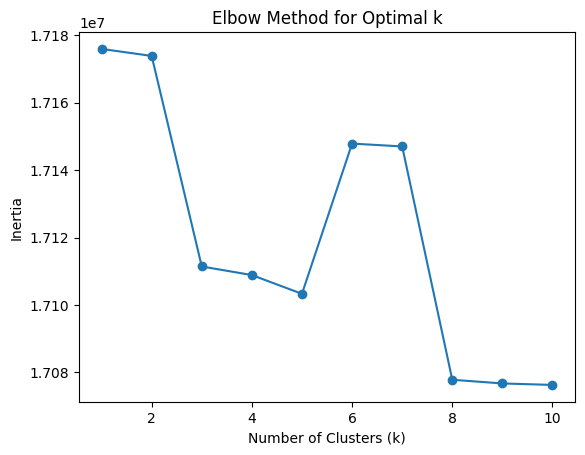

In [117]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

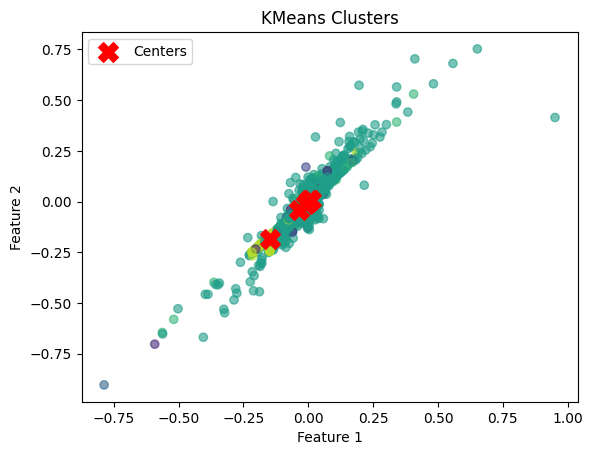

In [124]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(audio_data_arr[:, 0], audio_data_arr[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [49]:
all_mfcc_features = []
for data in audio_data_padded:
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=13)
    all_mfcc_features.append(mfcc.T)
    
all_mfcc_features = np.vstack(all_mfcc_features)
print("Combined MFCC Features Shape:", all_mfcc_features.shape)

Combined MFCC Features Shape: (4656476, 13)


In [50]:
inertia = []
K_range = range(55, 105, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)
    print(f'kmeans done with clusters {k}')

kmeans done with clusters 55
kmeans done with clusters 65
kmeans done with clusters 75
kmeans done with clusters 85
kmeans done with clusters 95


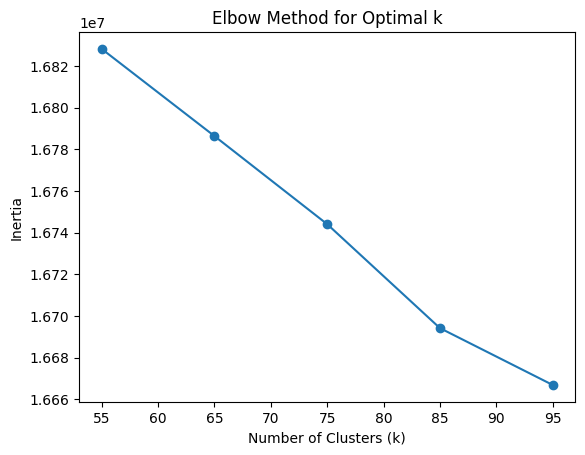

In [51]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [52]:
kmeans = KMeans(n_clusters=85, random_state=42)
kmeans.fit(audio_data_arr)

KMeans(n_clusters=85, random_state=42)

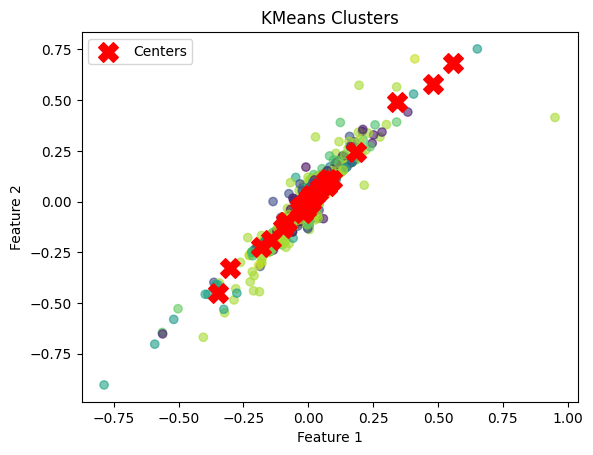

In [53]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(audio_data_arr[:, 0], audio_data_arr[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [54]:
inertia = []
K_range = range(5, 50, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_mfcc_features)
    inertia.append(kmeans.inertia_)
    print(f'kmeans done with clusters {k}')

kmeans done with clusters 5
kmeans done with clusters 15
kmeans done with clusters 25
kmeans done with clusters 35
kmeans done with clusters 45


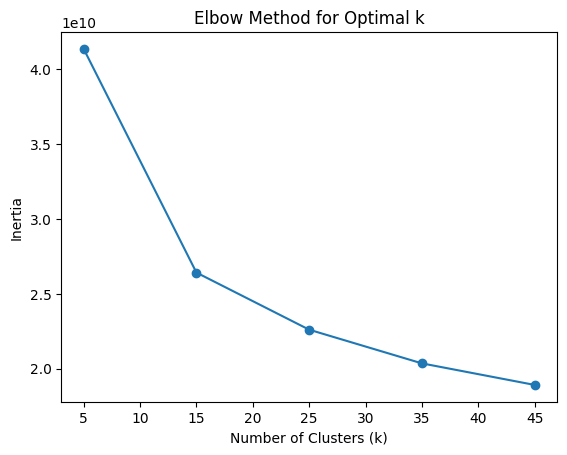

In [56]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [57]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(all_mfcc_features)

KMeans(n_clusters=15, random_state=42)

c:\Users\Parker\dev\Dev_School\Capstone\288R_Capstone\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


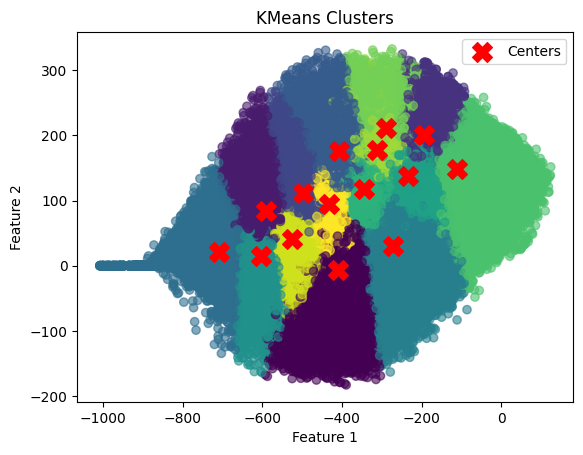

In [58]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(all_mfcc_features[:, 0], all_mfcc_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mfcc_reduced = pca.fit_transform(all_mfcc_features)

# Plot the clusters
plt.scatter(mfcc_reduced[:, 0], mfcc_reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clusters of MFCCs")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

## K Nearest Neighbors

In [14]:
# Setting up features array and labels

X = df_all.drop("Label", axis=1).values
y = df_all["Label"].values

In [16]:
from sklearn.model_selection import train_test_split

#Split the data into stratified training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=35)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 84668
Testing samples: 21167


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create the KNN classifier with a 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
# Predict labels for the test set
y_pred = knn.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
# Print the test accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Test Accuracy: 0.5269995748098455


C:\Users\shane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

_background_noise_       0.00      0.00      0.00         1
          backward       0.56      0.73      0.63       333
               bed       0.16      0.48      0.24       403
              bird       0.25      0.43      0.32       413
               cat       0.32      0.43      0.36       406
               dog       0.20      0.31      0.24       426
              down       0.30      0.51      0.38       783
             eight       0.67      0.67      0.67       757
              five       0.39      0.48      0.43       810
            follow       0.39      0.44      0.41       316
           forward       0.49      0.48      0.49       311
              four       0.57      0.59      0.58       746
                go       0.32      0.39      0.35       776
             happy       0.73      0.52      0.61       411
             house       0.73      0.62      0.67       423
             learn       0.40      0.35

C:\Users\shane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.model_selection import GridSearchCV

# Finding the optimal number of neighbors
param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]} 
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameter and best cross-validated score.
print("Best number of neighbors:", grid_search.best_params_['n_neighbors'])
print("Best cross-validation accuracy:", grid_search.best_score_)

Best number of neighbors: 30
Best cross-validation accuracy: 0.5482471991981737


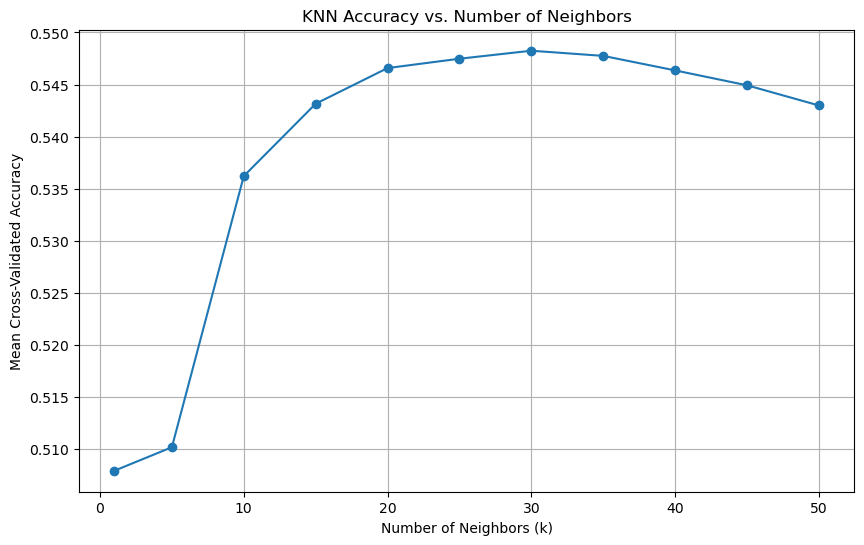

In [46]:
# Plotting how accuracy changes with different number of neighbors
mean_test_scores = grid_search.cv_results_['mean_test_score']
neighbor_values = param_grid['n_neighbors']

# Plot the figure
plt.figure(figsize=(10, 6))
plt.plot(neighbor_values, mean_test_scores, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [25]:
# Testing best number of neighbors on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.5608730571172108


In [49]:
from sklearn.decomposition import PCA
from collections import Counter
# Training KNN classifier with 30 neighbors and visualizing nearest neighbor distances

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

index = 100
sample = X_train[index].reshape(1, -1)
label = y_train[index]
predicted_label = knn.predict(sample)[0]

num_neighbors = 30

# Get the distances and indices of the top 50 nearest neighbors
distances, indices = knn.kneighbors(sample, n_neighbors=num_neighbors, return_distance=True)

# Extract the labels of the nearest neighbors.
neighbor_labels = [y_train[idx] for idx in indices[0]]

# Count the occurrence of each label among the neighbors.
label_counter = Counter(neighbor_labels)
total_neighbors = len(neighbor_labels)

# Printing true label and predicted label
print(f"Sample true label: {label}")
print(f"Sample predicted label: {predicted_label}\n")
print(f"Top {num_neighbors} nearest neighbors for the query sample:")

# Printing neighbors and distances
for rank, (idx, distance) in enumerate(zip(indices[0], distances[0]), start=1):
    neighbor_label = y_train[idx]
    print(f"Rank {rank}: Label = {neighbor_label}, Distance = {distance:.4f}")

# Print out the neighbor distribution.
print("Neighbor label distribution:")
for label, count in label_counter.items():
    percentage = (count / total_neighbors) * 100
    print(f"  {label}: {count}/{total_neighbors} ({percentage:.1f}%)")

Sample true label: go
Sample predicted label: go

Top 30 nearest neighbors for the query sample:
Rank 1: Label = go, Distance = 0.0000
Rank 2: Label = no, Distance = 466.2367
Rank 3: Label = go, Distance = 470.7139
Rank 4: Label = three, Distance = 477.3721
Rank 5: Label = wow, Distance = 478.9749
Rank 6: Label = learn, Distance = 479.4778
Rank 7: Label = learn, Distance = 483.8249
Rank 8: Label = go, Distance = 487.8314
Rank 9: Label = no, Distance = 493.2952
Rank 10: Label = no, Distance = 494.7860
Rank 11: Label = go, Distance = 494.9537
Rank 12: Label = go, Distance = 496.6866
Rank 13: Label = no, Distance = 497.9708
Rank 14: Label = go, Distance = 498.5218
Rank 15: Label = three, Distance = 500.7776
Rank 16: Label = no, Distance = 501.7851
Rank 17: Label = down, Distance = 505.1851
Rank 18: Label = up, Distance = 505.5997
Rank 19: Label = eight, Distance = 505.6412
Rank 20: Label = on, Distance = 511.3564
Rank 21: Label = five, Distance = 512.1544
Rank 22: Label = right, Distance 

The word 'go' was predicted correctly, but interesting that the word "no" had the same number of neighbors in the thirty closest neighbors as the correct label "go". In fact, the closest neighbor was the word "no" instead of the correct word "go". This makes sense as they both rhyme and might have very similar MFCCs. 

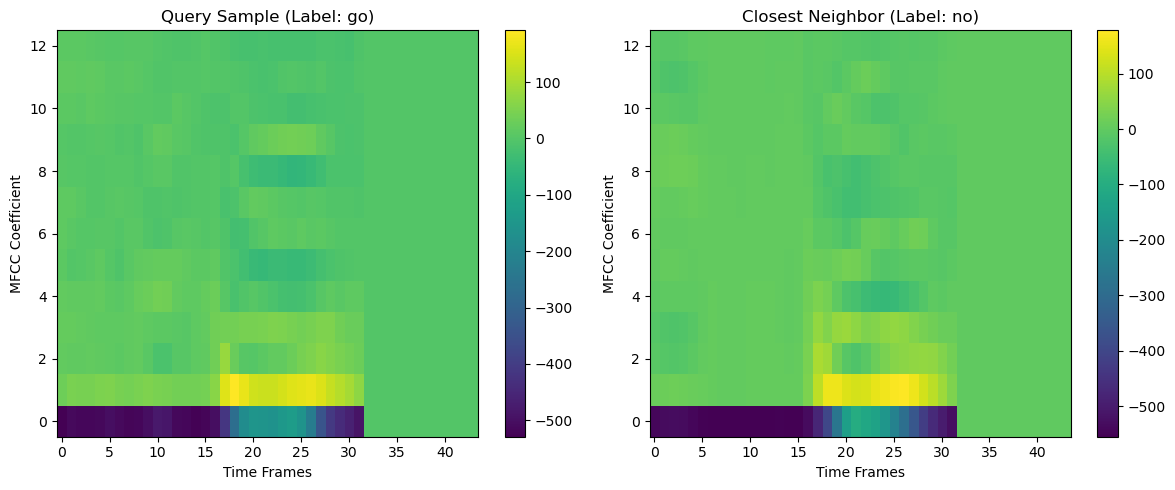

In [54]:
# Reshape the query sample's MFCC back to its 2D form.
query_mfcc = X_train[index].reshape(n_mfcc, max_pad_len)

# Select the second closest neighbor (index 1 in the sorted list).
second_neighbor_index = indices[0][1]
neighbor_mfcc = X_train[second_neighbor_index].reshape(n_mfcc, max_pad_len)

# Plot the MFCCs side by side for comparison.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot query sample MFCC.
im1 = axs[0].imshow(query_mfcc, aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title(f"Query Sample (Label: {y_train[index]})")
axs[0].set_xlabel("Time Frames")
axs[0].set_ylabel("MFCC Coefficient")
fig.colorbar(im1, ax=axs[0])

# Plot second closest neighbor MFCC.
im2 = axs[1].imshow(neighbor_mfcc, aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title(f"Closest Neighbor (Label: {y_train[second_neighbor_index]})")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("MFCC Coefficient")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()

We can see that the MFCCs are very similar for this recording of the word 'go' and the word 'no'.

## CNN - Pretrained EfficientNet

In [ ]:
pip install torch torchvision torchaudio matplotlib numpy opencv-python

#Expected Dataset Structure 


/dataset
    /train
        /class1
        /class2
        ...
    /val
        /class1
        /class2
        ...


In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# Image size for EfficientNet
IMG_SIZE = 128
BATCH_SIZE = 16

# Define transformations (normalize images)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

# Paths
data_dir = "data/images/Speech Commands (trimmed)"
validation_list_path = "validation_list.txt"
testing_list_path = "testing_list.txt"

# Load the validation and test filenames from the provided .txt files
def load_filenames(file_path):
    with open(file_path, "r") as f:
        return set(line.strip().replace(".wav", ".png") for line in f.readlines())

val_filenames = load_filenames(validation_list_path)
test_filenames = load_filenames(testing_list_path)  # Might be needed later

# Custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and d != "_background_noise_"])

        # Build dataset
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".png"):
                    file_path = os.path.join(class_name, filename)  # Relative path
                    if file_list is None or file_path in file_list:
                        self.data.append((file_path, self.classes.index(class_name)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        full_path = os.path.join(self.root_dir, img_path)
        image = Image.open(full_path).convert("RGB")  # Convert grayscale to RGB if needed

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = SpeechCommandsDataset(data_dir, file_list=None, transform=transform)  # All images except val/test
val_dataset = SpeechCommandsDataset(data_dir, file_list=val_filenames, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [16]:
import torch.nn as nn
import torchvision.models as models

# Load EfficientNet-B0 with pretrained ImageNet weights
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the classifier for your dataset
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names)),  # Adjust output to match your number of classes
    nn.LogSoftmax(dim=1)  # For classification tasks
)

# Check model structure
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Set up the training function and ensure you're using the MPS (Apple Metal) backend if on M1/M2.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [18]:
# Check if Metal (MPS) or CUDA is available, fallback to CPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Move model to device
# model = model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, print_every=10):
    for epoch in range(epochs):
        model.train()  # Set to training mode
        running_loss = 0.0
        correct, total = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every `print_every` batches
            if (batch_idx + 1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Complete, Avg Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


In [14]:
import torch

print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


Using device: cpu


In [20]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
#     for epoch in range(epochs):
#         model.train()  # Set to training mode
#         running_loss = 0.0
#         correct, total = 0, 0
        
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()  # Reset gradients
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
        
#         train_acc = 100 * correct / total
#         val_acc = evaluate_model(model, val_loader)
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

def evaluate_model(model, val_loader):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Train for 10 epochs
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SpeechCommandsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
# Save the Model
torch.save(model.state_dict(), "efficientnet_spoken_word.pth")


In [ ]:
# Load & Inference 

import cv2
import numpy as np
from PIL import Image

# Load the trained model
model.load_state_dict(torch.load("efficientnet_spoken_word.pth", map_location=device))
model.to(device)
model.eval()

# Load an image for prediction
image_path = "path_to_test_image.png"
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    output = model(image)
    _, predicted_class = torch.max(output, 1)

print(f"Predicted class: {class_names[predicted_class.item()]}")


Optimize for macos

Since you're running on a Mac, optimize further: ✅ Enable MPS Acceleration (Apple Metal for GPUs) → This is already handled with torch.device("mps").
✅ Reduce Image Size → Try (96, 96) for lower memory usage.
✅ Lower Batch Size → If memory errors occur, reduce BATCH_SIZE = 16.
✅ Use torch.compile (PyTorch 2.0+) → Speeds up training (if using PyTorch 2.0+):

In [ ]:
model = torch.compile(model)
